In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.metrics import f1_score, recall_score, accuracy_score
from pathlib import Path
import plotly.io as pio

# --- Path Definitions ---
# The notebook is in `./notebooks/final_evaluation/`, so the project root is two levels up.
NOTEBOOK_DIR = Path.cwd()
PROJECT_ROOT = NOTEBOOK_DIR.parent.parent
RESULTS_DIR = PROJECT_ROOT / "results"
INFERENCE_RESULTS_DIR = RESULTS_DIR / "inference"
DATA_DIR = PROJECT_ROOT / "data"
FINAL_DATASETS_DIR = DATA_DIR / "final-datasets"

print(f"Project Root identified at: {PROJECT_ROOT}")
print(f"Reading inference results from: {INFERENCE_RESULTS_DIR}")
print(f"Reading metadata from: {FINAL_DATASETS_DIR}")

# --- Plotly Configuration with Custom Monospace Font ---
# 1. Set the base theme
pio.templates.default = "plotly_white"

# 2. Define the font family. We use a "font stack" for broad compatibility.
# font_family = "'Roboto Mono', 'Courier New', monospace"
# font_family = "'Source Code Pro', 'Courier New', monospace"
font_family = "'Fira Code', 'Monaco', monospace"
# font_family = "'Consolas', 'Courier New', monospace"

# 3. Update the layout properties of the default template
#    This will apply the font to all future plots in this session.
pio.templates[pio.templates.default].layout.font.family = font_family
pio.templates[pio.templates.default].layout.hoverlabel.font.family = font_family

print(f"\nPlotly default font set to: {font_family}")


# --- Color Palette ---
PASTEL_COLORS = {
    'Fine-Tuned': '#636EFA',  # Muted Blue
    'Baseline': '#EF553B',   # Muted Red
    'Correct': '#00CC96',     # Muted Green
    'Conceptual Error': '#AB63FA', # Muted Purple
    'Computational Error': '#FFA15A', # Muted Orange
}

Project Root identified at: /Users/arvindsuresh/Documents/Github/Erdos-DL-June25-Math
Reading inference results from: /Users/arvindsuresh/Documents/Github/Erdos-DL-June25-Math/results/inference
Reading metadata from: /Users/arvindsuresh/Documents/Github/Erdos-DL-June25-Math/data/final-datasets

Plotly default font set to: 'Fira Code', 'Monaco', monospace


In [2]:
### Cell 2: Load and Prepare Data

def load_and_prepare_data():
    # --- Load Prediction Results ---
    sft_tuned_df = pd.read_csv(INFERENCE_RESULTS_DIR / "sft-test-set-predictions.csv")
    final_tuned_df = pd.read_csv(INFERENCE_RESULTS_DIR / "final-test-set-predictions.csv")
    sft_baseline_df = pd.read_csv(INFERENCE_RESULTS_DIR / "sft_test_set_results_baseline.csv")
    final_baseline_df = pd.read_csv(INFERENCE_RESULTS_DIR / "final_test_set_results_baseline.csv")

    # Add model and test_set identifiers
    sft_tuned_df['model'], sft_tuned_df['test_set'] = 'Fine-Tuned', 'SFT Test Set'
    final_tuned_df['model'], final_tuned_df['test_set'] = 'Fine-Tuned', 'Final Test Set'
    sft_baseline_df['model'], sft_baseline_df['test_set'] = 'Baseline', 'SFT Test Set'
    final_baseline_df['model'], final_baseline_df['test_set'] = 'Baseline', 'Final Test Set'

    # Add baseline latency
    sft_baseline_df['latency'] = 1.0
    final_baseline_df['latency'] = 1.0

    # Combine all results into one DataFrame
    all_results_df = pd.concat([sft_tuned_df, final_tuned_df, sft_baseline_df, final_baseline_df], ignore_index=True)

    # --- Load Metadata ---
    metadata_df = pd.read_csv(FINAL_DATASETS_DIR / "error_detection_dataset.csv")
    metadata_df = metadata_df[['index', 'tier', 'source', 'correct_answer_length', 'wrong_answer_length']]
    metadata_df['solution_length'] = metadata_df.apply(
        lambda row: row['correct_answer_length'] if pd.notna(row['correct_answer_length']) else row['wrong_answer_length'],
        axis=1
    )

    # --- Merge Results with Metadata ---
    # Use only the SFT test set portion of the metadata for merging, as it contains all unique indices.
    sft_metadata = metadata_df.drop_duplicates(subset=['index'])
    merged_df = pd.merge(all_results_df, sft_metadata, on='index', how='left')

    return merged_df

master_df = load_and_prepare_data()
print(f"Data loading and preparation complete. Master DataFrame has {len(master_df)} rows.")
master_df.info()

Data loading and preparation complete. Master DataFrame has 3032 rows.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3032 entries, 0 to 3031
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             1516 non-null   float64
 1   index                  2881 non-null   float64
 2   question               3032 non-null   object 
 3   answer                 3032 non-null   object 
 4   true_error_type        3032 non-null   object 
 5   pred_error_type        3032 non-null   object 
 6   raw_equations          3032 non-null   object 
 7   cleaned_equations      1516 non-null   object 
 8   is_correct             3032 non-null   bool   
 9   latency                3032 non-null   float64
 10  model                  3032 non-null   object 
 11  test_set               3032 non-null   object 
 12  tier                   2741 non-null   object 
 13  source                 2741 non-null 

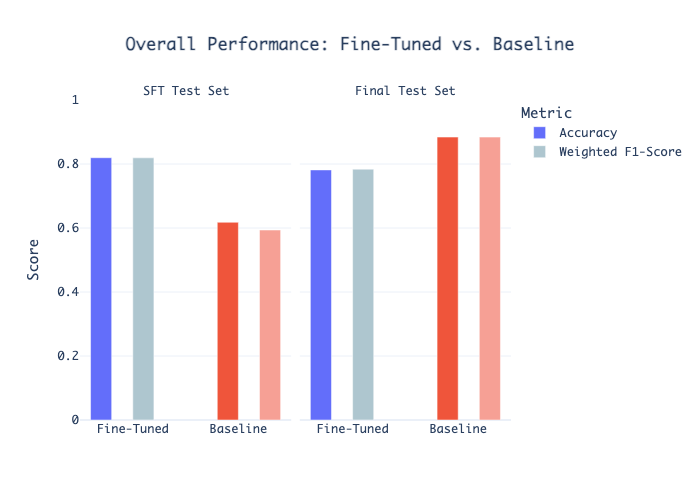

In [3]:
### Cell 3: Graph 1 - Key Performance Metrics (Accuracy & F1-Score)

def plot_main_metrics(df):
    metrics_data = []
    for test_set in ['SFT Test Set', 'Final Test Set']:
        for model in ['Fine-Tuned', 'Baseline']:
            subset = df[(df['test_set'] == test_set) & (df['model'] == model)]
            accuracy = accuracy_score(subset['true_error_type'], subset['pred_error_type'])
            f1 = f1_score(subset['true_error_type'], subset['pred_error_type'], average='weighted')
            metrics_data.append({'test_set': test_set, 'model': model, 'Accuracy': accuracy, 'Weighted F1-Score': f1})
    metrics_df = pd.DataFrame(metrics_data)

    melted_df = metrics_df.melt(
        id_vars=['test_set', 'model'],
        value_vars=['Accuracy', 'Weighted F1-Score'],
        var_name='Metric',
        value_name='Score'
    )
    
    melted_df['color_group'] = melted_df['model'] + ' - ' + melted_df['Metric']

    color_map = {
        'Fine-Tuned - Accuracy': '#636EFA',
        'Fine-Tuned - Weighted F1-Score': '#AEC6CF',
        'Baseline - Accuracy': '#EF553B',
        'Baseline - Weighted F1-Score': '#F6A095'
    }

    fig = px.bar(
        melted_df,
        x='model',
        y='Score',
        color='color_group',
        barmode='group',
        facet_col='test_set',
        title='<b>Overall Performance: Fine-Tuned vs. Baseline</b>',
        labels={'Score': 'Score', 'model': 'Model'},
        color_discrete_map=color_map,
        height=500,
        width=1100  # Fixed width for 2-panel plot
    )
    
    for trace in fig.data:
        original_name = trace.name
        metric_name = original_name.split(' - ')[-1]
        trace.name = metric_name
        if 'Baseline' in original_name:
            trace.showlegend = False

    fig.update_yaxes(range=[0, 1])
    fig.update_xaxes(title_text=None)
    fig.update_layout(legend_title_text='Metric', title_x=0.5)
    fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
    fig.show(renderer="png")

plot_main_metrics(master_df)

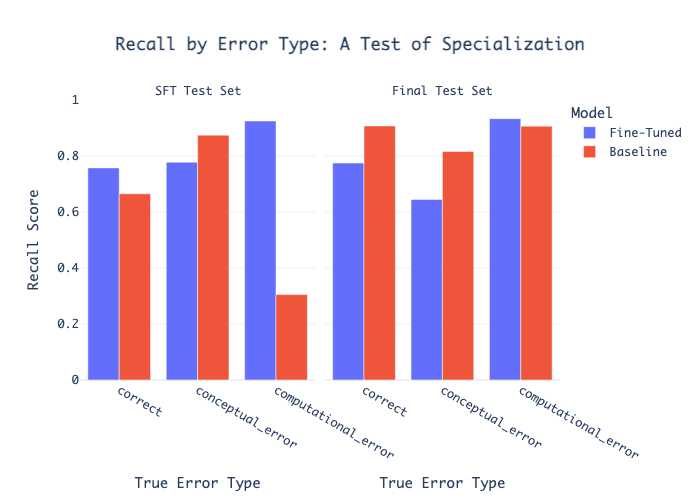

In [4]:
### Cell 4: Graph 2 - Recall by Error Type

def plot_recall_by_class(df):
    recall_data = []
    labels = ['correct', 'conceptual_error', 'computational_error']
    for test_set in ['SFT Test Set', 'Final Test Set']:
        for model in ['Fine-Tuned', 'Baseline']:
            subset = df[(df['test_set'] == test_set) & (df['model'] == model)]
            recalls = recall_score(subset['true_error_type'], subset['pred_error_type'], labels=labels, average=None, zero_division=0)
            for label, recall_val in zip(labels, recalls):
                recall_data.append({'test_set': test_set, 'model': model, 'Error Type': label, 'Recall': recall_val})

    recall_df = pd.DataFrame(recall_data)

    fig = px.bar(
        recall_df,
        x='Error Type',
        y='Recall',
        color='model',
        barmode='group',
        facet_col='test_set',
        title='<b>Recall by Error Type: A Test of Specialization</b>',
        labels={'Recall': 'Recall Score', 'Error Type': 'True Error Type'},
        color_discrete_map=PASTEL_COLORS,
        height=500,
        width=1100  # Fixed width for 2-panel plot
    )
    fig.update_yaxes(range=[0, 1])
    fig.update_layout(legend_title_text='Model', title_x=0.5)
    fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
    fig.show(renderer="png")

plot_recall_by_class(master_df)

/var/folders/yk/x70ww_h95d3fgd5spjp1s0780000gn/T/ipykernel_94522/934427332.py:4: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



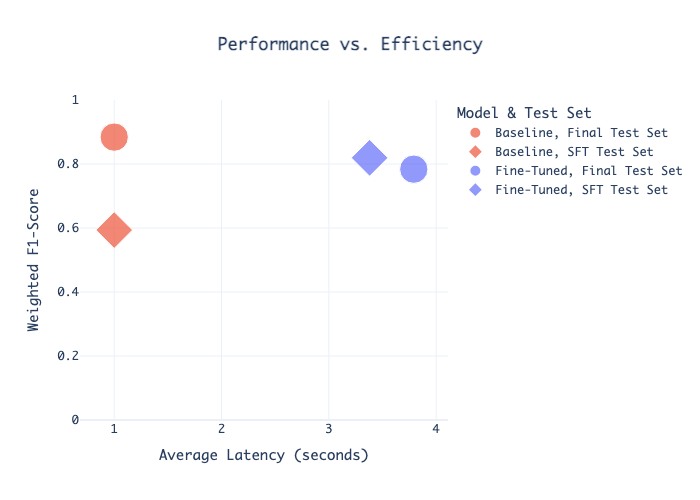

In [5]:
### Cell 5: Graph 3 - Performance vs. Efficiency (F1-Score vs. Latency)

def plot_performance_vs_efficiency(df):
    summary_data = df.groupby(['model', 'test_set']).apply(
        lambda g: pd.Series({
            'avg_latency': g['latency'].mean(),
            'weighted_f1': f1_score(g['true_error_type'], g['pred_error_type'], average='weighted')
        })
    ).reset_index()

    fig = px.scatter(
        summary_data,
        x='avg_latency',
        y='weighted_f1',
        color='model',
        symbol='test_set',
        size=[25] * len(summary_data),
        title='<b>Performance vs. Efficiency</b>',
        labels={'avg_latency': 'Average Latency (seconds)', 'weighted_f1': 'Weighted F1-Score'},
        color_discrete_map=PASTEL_COLORS,
        height=500,
        width=1000  # Fixed width for single-panel plot
    )
    fig.update_traces(textposition='top center')
    fig.update_layout(legend_title_text='Model & Test Set', title_x=0.5, yaxis=dict(range=[0, 1]))
    fig.show(renderer="png")

plot_performance_vs_efficiency(master_df)

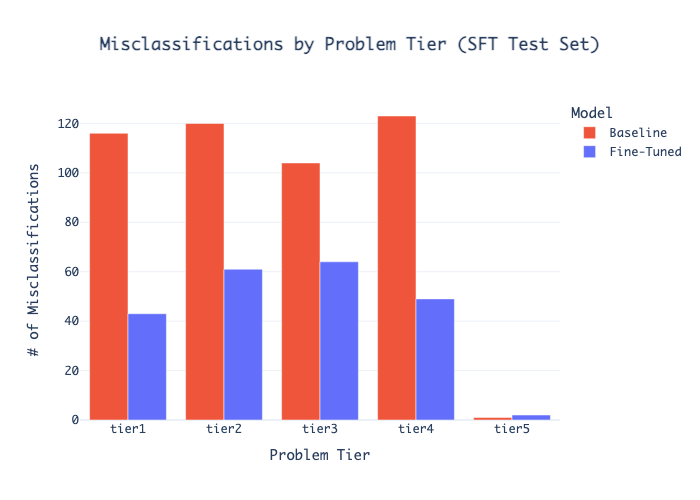

In [6]:
### Cell 6: Graph 4 - Misclassifications by Problem Tier

def plot_misclassifications_by_tier(df):
    misclass_df = df[(df['is_correct'] == False) & (df['test_set'] == 'SFT Test Set')]
    counts = misclass_df.groupby(['model', 'tier']).size().reset_index(name='count')
    
    fig = px.bar(
        counts,
        x='tier',
        y='count',
        color='model',
        barmode='group',
        title='<b>Misclassifications by Problem Tier (SFT Test Set)</b>',
        labels={'count': '# of Misclassifications', 'tier': 'Problem Tier'},
        category_orders={'tier': ['tier1', 'tier2', 'tier3', 'tier4']},
        color_discrete_map=PASTEL_COLORS,
        height=500,
        width=1000  # Fixed width for single-panel plot
    )
    fig.update_layout(legend_title_text='Model', title_x=0.5)
    fig.show(renderer="png")

plot_misclassifications_by_tier(master_df)

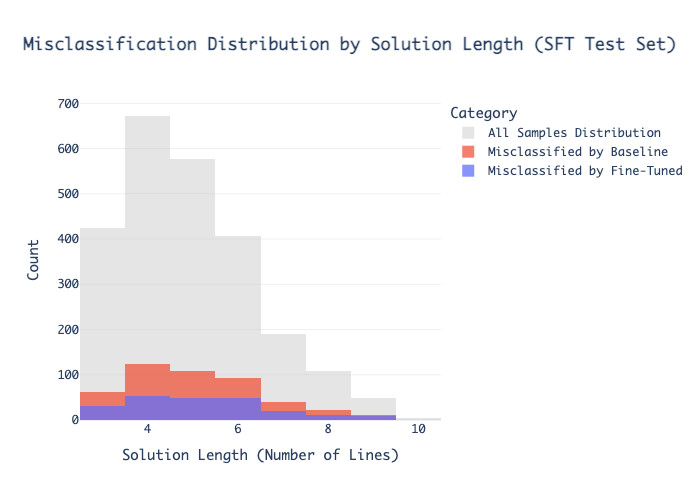

In [7]:
### Cell 7: Graph 5 - Misclassifications by Solution Length

def plot_misclassifications_by_length(df):
    df_sft = df[df['test_set'] == 'SFT Test Set'].dropna(subset=['solution_length'])
    misclass_df = df_sft[df_sft['is_correct'] == False]

    fig = go.Figure()

    fig.add_trace(go.Histogram(
        x=df_sft['solution_length'],
        name='All Samples Distribution',
        marker_color='#CCCCCC',
        opacity=0.5
    ))

    for model in ['Baseline', 'Fine-Tuned']:
        model_misclass = misclass_df[misclass_df['model'] == model]
        fig.add_trace(go.Histogram(
            x=model_misclass['solution_length'],
            name=f'Misclassified by {model}',
            marker_color=PASTEL_COLORS[model],
            opacity=0.75
        ))

    fig.update_layout(
        title_text='<b>Misclassification Distribution by Solution Length (SFT Test Set)</b>',
        xaxis_title_text='Solution Length (Number of Lines)',
        yaxis_title_text='Count',
        barmode='overlay',
        legend_title_text='Category',
        title_x=0.5,
        height=500,
        width=1000  # Fixed width for single-panel plot
    )
    fig.show(renderer="png")

plot_misclassifications_by_length(master_df)

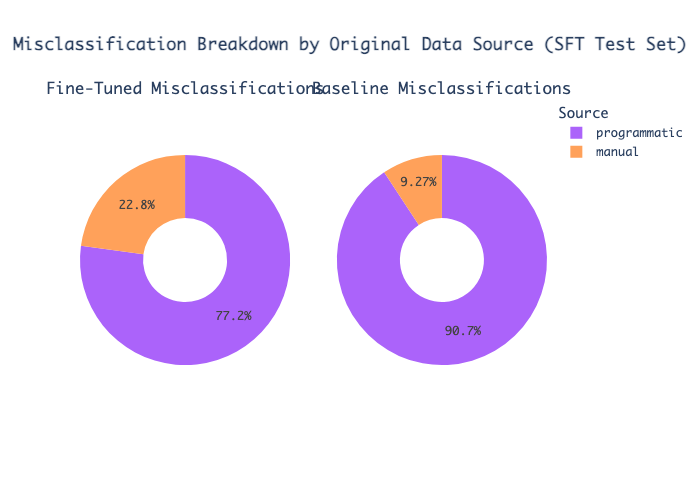

In [8]:
### Cell 8: Graph 6 - Misclassifications by Data Source

def plot_misclassifications_by_source(df):
    misclass_df = df[(df['is_correct'] == False) & (df['test_set'] == 'SFT Test Set')]
    
    fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]],
                        subplot_titles=['Fine-Tuned Misclassifications', 'Baseline Misclassifications'])

    for i, model in enumerate(['Fine-Tuned', 'Baseline']):
        subset = misclass_df[misclass_df['model'] == model]
        counts = subset['source'].value_counts()
        fig.add_trace(go.Pie(
            labels=counts.index,
            values=counts.values,
            name=model,
            marker_colors=['#AB63FA', '#FFA15A']
        ), 1, i+1)

    fig.update_traces(hole=.4, hoverinfo="label+percent+value")
    fig.update_layout(
        title_text="<b>Misclassification Breakdown by Original Data Source (SFT Test Set)</b>",
        title_x=0.5,
        legend_title_text='Source',
        height=500,
        width=1000  # Fixed width for 2-panel plot
    )
    fig.show(renderer="png")

plot_misclassifications_by_source(master_df)

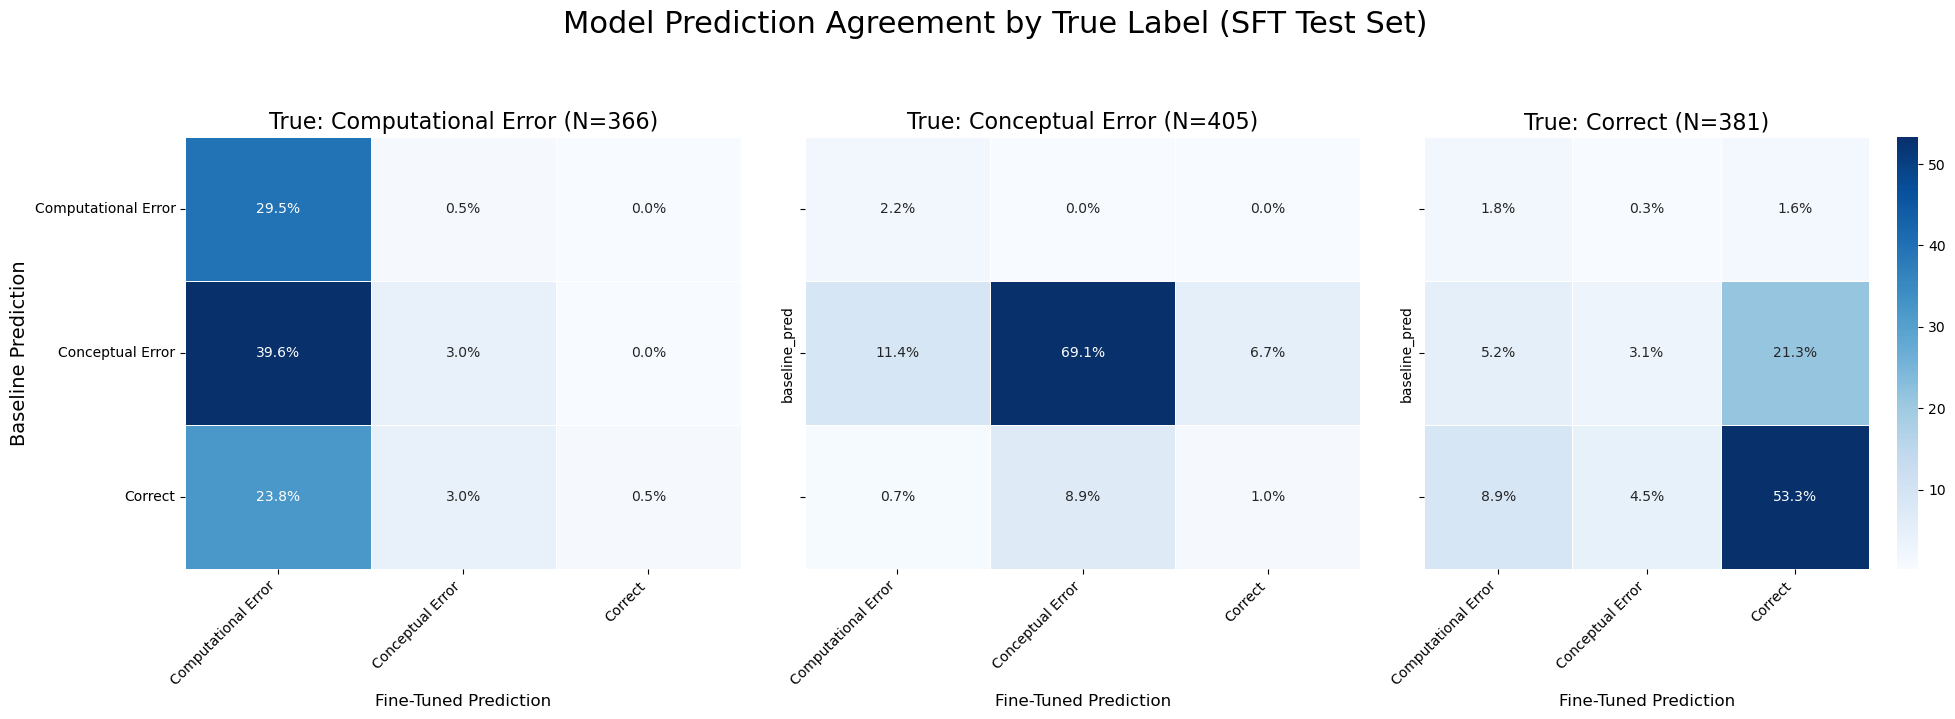

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def create_wide_df_for_comparison(df):
    """
    Pivots the long-format master_df to a wide format where each row is a unique
    sample, with columns for the predictions of each model.
    """
    subset = df[['index', 'test_set', 'true_error_type', 'model', 'pred_error_type']]
    
    wide_df = subset.pivot_table(
        index=['index', 'test_set', 'true_error_type'],
        columns='model',
        values='pred_error_type',
        aggfunc='first'
    ).reset_index()
    
    wide_df.rename(columns={'Baseline': 'baseline_pred', 'Fine-Tuned': 'fine_tuned_pred'}, inplace=True)
    return wide_df

def plot_agreement_matrix_seaborn(df):
    """
    Creates a 1x3 subplot grid using Seaborn, where each subplot is a heatmap
    showing the agreement between the two models for a specific true label.
    """
    wide_df = create_wide_df_for_comparison(df)
    
    labels = ['computational_error', 'conceptual_error', 'correct']
    pretty_labels = [l.replace('_', ' ').title() for l in labels]
    
    # --- Create Matplotlib figure and axes for a 1x3 grid ---
    fig, axes = plt.subplots(1, 3, figsize=(20, 7), sharey=True)
    fig.suptitle('Model Prediction Agreement by True Label (SFT Test Set)', fontsize=22, y=1.02)

    for i, true_label in enumerate(labels):
        ax = axes[i]
        subset = wide_df[wide_df['true_error_type'] == true_label]
        N = len(subset)
        if N == 0:
            ax.text(0.5, 0.5, 'No Data', ha='center', va='center')
            ax.set_title(f"True: {pretty_labels[i]} (N=0)")
            continue

        crosstab = pd.crosstab(subset['baseline_pred'], subset['fine_tuned_pred'])
        crosstab = crosstab.reindex(index=labels, columns=labels, fill_value=0)
        percentage_matrix = (crosstab / N) * 100

        # Create formatted labels for annotation (e.g., "29.5%")
        annot_labels = (np.asarray(["{0:.1f}%".format(val) for val in percentage_matrix.to_numpy().flatten()])).reshape(3, 3)

        # --- Draw the heatmap using Seaborn ---
        sns.heatmap(
            percentage_matrix,
            ax=ax,
            annot=annot_labels,
            fmt='', # Pass empty fmt since annot is pre-formatted
            cmap='Blues',
            linewidths=.5,
            cbar= i == 2 # Only show colorbar on the last plot
        )
        
        ax.set_title(f"True: {pretty_labels[i]} (N={N})", fontsize=16)
        ax.set_xlabel("Fine-Tuned Prediction", fontsize=12)
        ax.set_xticklabels(pretty_labels, rotation=45, ha="right")
        ax.set_yticklabels(pretty_labels, rotation=0)

    # Set the y-axis label only for the first subplot to avoid clutter
    axes[0].set_ylabel("Baseline Prediction", fontsize=14)
    
    # Adjust layout to prevent titles/labels from overlapping
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Run the analysis on the SFT Test Set
plot_agreement_matrix_seaborn(master_df[master_df['test_set'] == 'SFT Test Set'])